# Setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import numpy as np
from disambiguation import Disambiguator, Disambiguator1880
import disambiguation.analysis as da
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
pd.set_option('display.min_rows', 1000)
pd.set_option('display.max_columns', 55)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
match = pd.read_csv("../data/matches.csv")

In [4]:
census_latlng = pd.read_csv("../data/census_1880_mn_v04.csv")

# Generating Test Set

In [5]:
census_latlng.head()

,OBJECTID.x,CENSUS_MERGEID,CENSUS_SERIALB,CENSUS_SERIAL,CENSUS_PERNUM,CENSUS_RECIDUS,CENSUS_REEL,CENSUS_VOLUME,CENSUS_PAGENUM,CENSUS_NAMEFRSTB,CENSUS_NAMELASTB,CENSUS_RELATE,CENSUS_RELATE_STR,CENSUS_AGE,CENSUS_SEXB,CENSUS_RACENAMEB,CENSUS_RACEB,CENSUS_NPERHHB,CENSUS_OCCLABELB,CENSUS_SEIUSBN,CENSUS_MATCH_ADDR,CENSUS_HOUSE_NUMB,CENSUS_STREETB,CENSUS_TYPEB,CENSUS_SEGMENT_ID,CENSUS_BUILDING_I,CENSUS_NEIGHBOR_1,CENSUS_NEIGHBOR_2,CENSUS_SEGGROUP_I,CENSUS_EXTGROUP_I,CENSUS_CITY,CENSUS_COUNTYUS,CENSUS_X,CENSUS_Y,CENSUS_ADDRESS,CENSUS_ENUMDIST,CENSUS_CITYNAME,CENSUS_STATENAME,CENSUS_UNITTYPE,MERGE_SRC,WARD_NUM,CENSUS_AD
0,1,46101106EDITH K.SANGER,6347938,6198399,3,01254866-1-0001-0003-$,866,1,1,EDITH K.,SANGER,301,Child,1,2,white,100,6,*,0,"36 GOVERNORS ISLAND, NYC-Manhattan, NY",0,36,Gov,2,2,49374,49376,49373,446,4610,610,-74.01675,40.69071,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.00000,1.00000
1,2,461012776EMMAVAN BROSELIN,6347938,6198399,6,01254866-1-0001-0006-$,866,1,1,EMMA,VAN BROSELIN,1200,Other non-relatives,27,2,black,200,6,DOMESTIC SERVANT,7,"36 GOVERNORS ISLAND, NYC-Manhattan, NY",0,36,Gov,2,2,49374,49376,49373,446,4610,610,-74.01675,40.69071,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.00000,1.00000
2,3,461012776LIZZIEMALONE,6347938,6198399,4,01254866-1-0001-0004-$,866,1,1,LIZZIE,MALONE,1200,Other non-relatives,27,2,black,200,6,DOMESTIC SERVANT,7,"36 GOVERNORS ISLAND, NYC-Manhattan, NY",0,36,Gov,2,2,49374,49376,49373,446,4610,610,-74.01675,40.69071,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.00000,1.00000
3,4,461012806FANNIE K.SANGER,6347938,6198399,2,01254866-1-0001-0002-$,866,1,1,FANNIE K.,SANGER,201,Spouse,28,2,white,100,6,NONE,0,"36 GOVERNORS ISLAND, NYC-Manhattan, NY",0,36,Gov,2,2,49374,49376,49373,446,4610,610,-74.01675,40.69071,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.00000,1.00000
4,5,461012876MITCHILL A.LEE,6347938,6198399,5,01254866-1-0001-0005-$,866,1,1,MITCHILL A.,LEE,1200,Other non-relatives,28,1,black,200,6,DOMESTIC SERVANT,7,"36 GOVERNORS ISLAND, NYC-Manhattan, NY",0,36,Gov,2,2,49374,49376,49373,446,4610,610,-74.01675,40.69071,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.00000,1.00000


In [6]:
census_latlng = census_latlng.loc[:, ['CENSUS_MATCH_ADDR', 'CENSUS_X', 'CENSUS_Y']].drop_duplicates()

In [7]:
benchmark = match.merge(census_latlng, how='left', on='CENSUS_MATCH_ADDR', validate='many_to_one')

In [8]:
benchmark.head()

,Unnamed: 0,CD_ID,CD_FIRST_NAME,CD_LAST_NAME,MATCH_ADDR,CD_OCCUPATION,num_matches,CENSUS_ID,CENSUS_NAMEFRSCLEAN,CENSUS_NAMELASTB,CENSUS_MATCH_ADDR,CENSUS_AGE,CENSUS_OCCLABELB,WARD_NUM,CENSUS_ENUMDIST,CENSUS_SEGMENT_ID,CD_BLOCK_NUM,census_occupation_listed,jaro_winkler_aggr_score,confidence_score,LONG,LAT,age_score,census_count,CENSUS_X,CENSUS_Y
0,43236,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_172,PATRICK,MURPHY,"42 GOVERNORS ISLAND, NYC-Manhattan, NY",39,"CLERK, U.S. ARMY",1,1,2,3783,1,1.00000,0.85000,-74.01085,40.70374,1,1,-74.01658,40.69059
1,14137,CD_24242,George,Suau,"129 BROAD ST, New York, NY",mer,2,CENSUS_306,GEORGE,SWEE,"22 GOVERNORS ISLAND, NYC-Manhattan, NY",5,*,1,1,2,3798,0,0.73000,0.66000,-74.01110,40.70195,0,1,-74.01714,40.69100
2,47741,CD_80330,John,Moller,"14 STATE ST, New York, NY",clerk,2,CENSUS_317,JOHN,MULLER,"87 GOVERNORS ISLAND, NYC-Manhattan, NY",22,SOLDIER,1,1,2,649,1,0.94000,0.87000,-74.01430,40.70308,1,1,-74.01525,40.68977
3,114669,CD_185397,James,Costello,"49 WHITEHALL ST, New York, NY",liquors,1,CENSUS_359,JAMES,COSTELA,"87 GOVERNORS ISLAND, NYC-Manhattan, NY",29,SOLDIER,1,1,2,3780,1,0.92800,0.96000,-74.01269,40.70231,1,1,-74.01525,40.68977
4,84448,CD_137772,John,Hazeltine,"17 STONE ST, New York, NY",NaN,2,CENSUS_361,JOHN,HESELTINE,"87 GOVERNORS ISLAND, NYC-Manhattan, NY",29,SOLDIER,1,1,2,3801,1,0.92200,0.86000,-74.01207,40.70411,1,1,-74.01525,40.68977


In [9]:
import re
def get_hn(add):
    hn = re.search('[0-9]+', add)
    return hn.group()

def get_st(add):
    try:
        st = re.search('(?<=[0-9]\\s)([A-Z]|\\s)+(?=,)', add)
        return st.group()
    except:
        return None

print( get_hn("71 PEARL ST") )
print( get_st("71 PEARL ST, NEW YORK, NY") )

71
PEARL ST


In [10]:
benchmark['cd_hn'] = benchmark.apply(lambda row: get_hn(row.MATCH_ADDR), axis=1)
benchmark['cen_hn'] = benchmark.apply(lambda row: get_hn(row.CENSUS_MATCH_ADDR), axis=1)
benchmark['cd_add_cln'] = benchmark.apply(lambda row: get_st(row.MATCH_ADDR), axis=1)
benchmark['cen_add_cln'] = benchmark.apply(lambda row: get_st(row.CENSUS_MATCH_ADDR), axis=1)

In [11]:
benchmark.head()

,Unnamed: 0,CD_ID,CD_FIRST_NAME,CD_LAST_NAME,MATCH_ADDR,CD_OCCUPATION,num_matches,CENSUS_ID,CENSUS_NAMEFRSCLEAN,CENSUS_NAMELASTB,CENSUS_MATCH_ADDR,CENSUS_AGE,CENSUS_OCCLABELB,WARD_NUM,CENSUS_ENUMDIST,CENSUS_SEGMENT_ID,CD_BLOCK_NUM,census_occupation_listed,jaro_winkler_aggr_score,confidence_score,LONG,LAT,age_score,census_count,CENSUS_X,CENSUS_Y,cd_hn,cen_hn,cd_add_cln,cen_add_cln
0,43236,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_172,PATRICK,MURPHY,"42 GOVERNORS ISLAND, NYC-Manhattan, NY",39,"CLERK, U.S. ARMY",1,1,2,3783,1,1.00000,0.85000,-74.01085,40.70374,1,1,-74.01658,40.69059,71,42,PEARL ST,GOVERNORS ISLAND
1,14137,CD_24242,George,Suau,"129 BROAD ST, New York, NY",mer,2,CENSUS_306,GEORGE,SWEE,"22 GOVERNORS ISLAND, NYC-Manhattan, NY",5,*,1,1,2,3798,0,0.73000,0.66000,-74.01110,40.70195,0,1,-74.01714,40.69100,129,22,BROAD ST,GOVERNORS ISLAND
2,47741,CD_80330,John,Moller,"14 STATE ST, New York, NY",clerk,2,CENSUS_317,JOHN,MULLER,"87 GOVERNORS ISLAND, NYC-Manhattan, NY",22,SOLDIER,1,1,2,649,1,0.94000,0.87000,-74.01430,40.70308,1,1,-74.01525,40.68977,14,87,STATE ST,GOVERNORS ISLAND
3,114669,CD_185397,James,Costello,"49 WHITEHALL ST, New York, NY",liquors,1,CENSUS_359,JAMES,COSTELA,"87 GOVERNORS ISLAND, NYC-Manhattan, NY",29,SOLDIER,1,1,2,3780,1,0.92800,0.96000,-74.01269,40.70231,1,1,-74.01525,40.68977,49,87,WHITEHALL ST,GOVERNORS ISLAND
4,84448,CD_137772,John,Hazeltine,"17 STONE ST, New York, NY",NaN,2,CENSUS_361,JOHN,HESELTINE,"87 GOVERNORS ISLAND, NYC-Manhattan, NY",29,SOLDIER,1,1,2,3801,1,0.92200,0.86000,-74.01207,40.70411,1,1,-74.01525,40.68977,17,87,STONE ST,GOVERNORS ISLAND


In [12]:
benchmark['add_match'] = np.where(benchmark.cd_hn == benchmark.cen_hn, 0.1, 0) + np.where(benchmark.cen_add_cln == benchmark.cd_add_cln, 0.9, 0)

In [13]:
benchmark['confidence_score'] = benchmark['confidence_score'] + benchmark['add_match']

In [14]:
benchmark = da.get_dist_based_match(benchmark)['results']

In [15]:
benchmark.head()

,Unnamed: 0,CD_ID,CD_FIRST_NAME,CD_LAST_NAME,MATCH_ADDR,CD_OCCUPATION,num_matches,CENSUS_ID,CENSUS_NAMEFRSCLEAN,CENSUS_NAMELASTB,CENSUS_MATCH_ADDR,CENSUS_AGE,CENSUS_OCCLABELB,WARD_NUM,CENSUS_ENUMDIST,CENSUS_SEGMENT_ID,CD_BLOCK_NUM,census_occupation_listed,jaro_winkler_aggr_score,confidence_score,LONG,LAT,age_score,census_count,CENSUS_X,CENSUS_Y,cd_hn,cen_hn,cd_add_cln,cen_add_cln,add_match,dist,dist_weight,selected,graph_ID
0,43236,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_172,PATRICK,MURPHY,"42 GOVERNORS ISLAND, NYC-Manhattan, NY",39,"CLERK, U.S. ARMY",1,1,2,3783,1,1.00000,0.85000,-74.01085,40.70374,1,1,-74.01658,40.69059,71,42,PEARL ST,GOVERNORS ISLAND,0.00000,1540.21310,0.99000,0.00000,0
1,43233,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_1537,PATRICK,MURPHY,"57 PEARL ST, NYC-Manhattan, NY",44,EXPRESSMAN,1,1,41,3783,1,1.00000,1.75000,-74.01085,40.70374,1,1,-74.01138,40.70359,71,57,PEARL ST,PEARL ST,0.90000,47.17421,2.01000,1.00000,0
2,43235,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_3399,PATRICK,MURPHEY,"26 CASTLE PARK, NYC-Manhattan, NY",24,LABORER,1,1,64,3783,1,0.97600,0.84000,-74.01085,40.70374,1,1,-74.01655,40.70456,71,26,PEARL ST,CASTLE PARK,0.00000,488.53956,1.00000,0.00000,0
3,43234,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_3783,PATRICK,MURPHY,"26 CASTLE PARK, NYC-Manhattan, NY",30,LABORER,1,1,64,3783,1,1.00000,0.85000,-74.01085,40.70374,1,1,-74.01655,40.70456,71,26,PEARL ST,CASTLE PARK,0.00000,488.53956,1.01000,0.00000,0
4,14137,CD_24242,George,Suau,"129 BROAD ST, New York, NY",mer,2,CENSUS_306,GEORGE,SWEE,"22 GOVERNORS ISLAND, NYC-Manhattan, NY",5,*,1,1,2,3798,0,0.73000,0.66000,-74.01110,40.70195,0,1,-74.01714,40.69100,129,22,BROAD ST,GOVERNORS ISLAND,0.00000,1319.87053,0.80000,0.00000,1


In [52]:
benchmark_addr_success = da.get_addr_success(benchmark)
benchmark_addr_success

{'n_perfect_match_chosen': 29927, 'n_perfect_match': 36480}

# Fill down

In [16]:
fill_down = match
fill_down['CENSUS_X'] = np.where(fill_down['confidence_score'] == 1, fill_down['LONG'], None)
fill_down['CENSUS_Y'] = np.where(fill_down['confidence_score'] == 1, fill_down['LAT'], None)
fill_down['CENSUS_X'] = fill_down['CENSUS_X'].fillna(method='ffill').fillna(method='backfill')
fill_down['CENSUS_Y'] = fill_down['CENSUS_Y'].fillna(method='ffill').fillna(method='backfill')

In [17]:
fill_down_df = da.get_dist_based_match(match)['results']

In [18]:
fill_down_match_rate = da.get_match_rate(fill_down_df)
fill_down_addr_success = da.get_addr_success(fill_down_df)
fill_down_dist_error = da.get_dist_error(fill_down_df)
fill_down_under12 = da.get_under12_selections(fill_down_df)

In [19]:
fill_down_cm = da.compare_selections(fill_down_df, benchmark)['confusion_matrix']

In [20]:
print(fill_down_match_rate)
print(fill_down_addr_success)
print(fill_down_dist_error['dist'].describe())
print(fill_down_under12)
print(fill_down_cm)

98.97
{'n_perfect_match_chosen': 28649, 'n_perfect_match': 36480}
count   138242.00000
mean        24.84959
std         80.62666
min          0.00000
25%          0.00000
50%          0.00000
75%         14.45250
max       4588.54161
Name: dist, dtype: float64
2.93
[[99579, 4431], [4431, 29801]]


# K-Between

In [29]:
basic = Disambiguator1880(match)
basic.run_disambiguation()

Running
Creating dictionary of sub dfs (1/4)...
Applying algorithms iteratively (2/4)...
Cleaning output (3/4)...
Disambiguating (4/4)...
Done! :)


In [30]:
len(basic.get_result())

138242

In [38]:
basic_match_rate = da.get_match_rate(basic_df)
basic_addr_success = da.get_addr_success(basic_df)
basic_dist_error = da.get_dist_error(basic_df)
basic_under12 = da.get_under12_selections(basic_df)

In [39]:
basic_cm = da.compare_selections(basic_df, benchmark)['confusion_matrix']

In [40]:
print(basic_match_rate)
print(basic_addr_success)
print(basic_dist_error['dist'].describe())
print(basic_under12)
print(basic_cm)

98.97
{'n_perfect_match_chosen': 29124, 'n_perfect_match': 36480}
count   138242.00000
mean        24.84959
std         80.62666
min          0.00000
25%          0.00000
50%          0.00000
75%         14.45250
max       4588.54161
Name: dist, dtype: float64
2.16
[[100574, 3436], [3436, 30796]]


In [41]:
kbest = da.compare_selections(basic_df, benchmark)['merged_df']

In [42]:
kbest.head()

,Unnamed: 0,CD_ID,CD_FIRST_NAME,CD_LAST_NAME,MATCH_ADDR,CD_OCCUPATION,num_matches,CENSUS_ID,CENSUS_NAMEFRSCLEAN,CENSUS_NAMELASTB,CENSUS_MATCH_ADDR,CENSUS_AGE,CENSUS_OCCLABELB,WARD_NUM,CENSUS_ENUMDIST,CENSUS_SEGMENT_ID,CD_BLOCK_NUM,census_occupation_listed,jaro_winkler_aggr_score,confidence_score,LONG,LAT,age_score,census_count,CENSUS_X,CENSUS_Y,dist,dist_weight,anchor,group_ID,node_ID,letter,in_cluster,key,spatial_weight,selected_algo,graph_ID,cd_add_cln,cen_add_cln,selected_dist
0,43236,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_172,PATRICK,MURPHY,"42 GOVERNORS ISLAND, NYC-Manhattan, NY",39,"CLERK, U.S. ARMY",1,1,2,3783,1,1.00000,0.85000,-74.01085,40.70374,1,1,-74.01295,40.70249,224.94258,1.03000,0,0.00000,NaN,NaN,nan,nan,1.85000,1.00000,0,71 PEARL ST,42 GOVERNORS ISLAND,0.00000
1,43233,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_1537,PATRICK,MURPHY,"57 PEARL ST, NYC-Manhattan, NY",44,EXPRESSMAN,1,1,41,3783,1,1.00000,0.85000,-74.01085,40.70374,1,1,-74.01146,40.70389,53.72688,1.10000,0,46.00000,N7_0,N7,0.00000,0.00000,1.85000,0.00000,0,71 PEARL ST,57 PEARL ST,1.00000
2,43235,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_3399,PATRICK,MURPHEY,"26 CASTLE PARK, NYC-Manhattan, NY",24,LABORER,1,1,64,3783,1,0.97600,0.84000,-74.01085,40.70374,1,1,-74.01368,40.70248,276.06464,1.02000,0,54.00000,N8_0,N8,-1.00000,0.00000,1.84000,0.00000,0,71 PEARL ST,26 CASTLE PARK,0.00000
3,43234,CD_74371,Patrick,Murphy,"71 PEARL ST, New York, NY",express,4,CENSUS_3783,PATRICK,MURPHY,"26 CASTLE PARK, NYC-Manhattan, NY",30,LABORER,1,1,64,3783,1,1.00000,0.85000,-74.01085,40.70374,1,1,-74.00994,40.70487,147.08865,1.05000,0,55.00000,N1_0,N1,0.00000,0.00000,1.85000,0.00000,0,71 PEARL ST,26 CASTLE PARK,0.00000
4,14137,CD_24242,George,Suau,"129 BROAD ST, New York, NY",mer,2,CENSUS_306,GEORGE,SWEE,"22 GOVERNORS ISLAND, NYC-Manhattan, NY",5,*,1,1,2,3798,0,0.73000,0.66000,-74.01110,40.70195,0,1,-74.01295,40.70249,166.84776,0.86000,0,0.00000,NaN,NaN,nan,nan,1.66000,1.00000,1,129 BROAD ST,22 GOVERNORS ISLAND,0.00000


In [44]:
import geopandas as gpd

In [47]:
# why are there still 4000
ed = gpd.read_file("../data/ed_1880_boundaries/ED_1880_mn.shp")
ed = ed.dissolve(by = 'ed80').reset_index()
max_dist = kbest.loc[kbest.selected_algo == 1, :].groupby('CENSUS_ENUMDIST').agg({'dist': 'max'}).reset_index()
ed_merged = ed.merge(max_dist, how='left', left_on='ed80', right_on='CENSUS_ENUMDIST', validate='one_to_one')

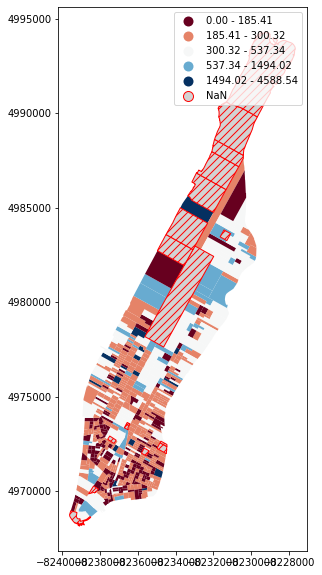

In [48]:
ed_merged.plot(column='dist', cmap='RdBu', figsize=(15,10), legend=True, scheme='natural_breaks', missing_kwds = {'color': 'lightgrey', 'edgecolor': 'red', 'hatch': '///'})

In [56]:
ed_merged.loc[ed_merged.dist > 1500, ['ed80', 'dist']]

,ed80,dist
99,99,4588.54161
157,157,1867.71548
192,192,3071.10625
300,300,4070.10435
355,355,2540.61839
377,377,3568.31763
402,402,2192.54529
440,440,2763.83148
461,461,1837.52474
468,468,1650.13524


In [67]:
false_rate = kbest
false_rate['false_select'] = np.where(false_rate['selected_algo'] != false_rate['selected_dist'], 1, 0)
false_rate = false_rate.groupby('CENSUS_ENUMDIST').agg({'false_select': 'count'}).reset_index()
ed_false = ed.merge(false_rate, how='left', left_on='ed80', right_on='CENSUS_ENUMDIST', validate='one_to_one')

In [69]:
false_rate['false_select'].describe()

count   644.00000
mean    214.66149
std      88.64743
min       3.00000
25%     155.00000
50%     211.00000
75%     269.25000
max     577.00000
Name: false_select, dtype: float64

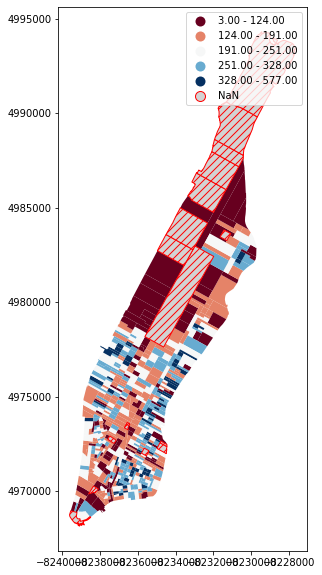

In [68]:
ed_false.plot(column='false_select', cmap='RdBu', figsize=(15,10), legend=True, scheme='natural_breaks', missing_kwds = {'color': 'lightgrey', 'edgecolor': 'red', 'hatch': '///'})

In [49]:
kbest.to_csv("../data/disambiguated_final_v2.csv", index=False)

In [53]:
kbest.to_csv("matching_viz/data/matched_viz_v3.csv", index=False)

**What is the cause of the long error distances?**

In [57]:
kbest_algo_sel = kbest.loc[kbest.selected_algo > kbest.selected_dist, :]
kbest_dist_sel = kbest.loc[kbest.selected_algo < kbest.selected_dist, :]

In [58]:
error_eda = kbest_algo_sel.merge(kbest_dist_sel, how='inner', on='CD_ID', validate='one_to_one')

In [59]:
confidence_error = error_eda.loc[(error_eda.confidence_score_x != error_eda.confidence_score_y), :]
spatial_weight_error = error_eda.loc[(error_eda.spatial_weight_x != error_eda.spatial_weight_y) & (error_eda.confidence_score_x != error_eda.confidence_score_y), :]
no_error = error_eda.loc[error_eda.spatial_weight_x == error_eda.spatial_weight_y, :]

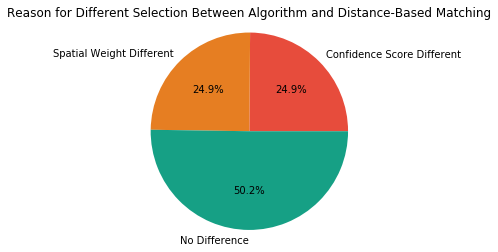

In [61]:
error_labels = ['Confidence Score Different', 'Spatial Weight Different', 'No Difference']
errors = [len(confidence_error), len(spatial_weight_error), len(no_error)]

fig1, ax1 = plt.subplots()
ax1.pie(errors, labels=error_labels, autopct='%1.1f%%', colors=["#e74c3c", "#e67e22", "#16a085"])
ax1.axis('equal')
plt.title("Reason for Different Selection Between Algorithm and Distance-Based Matching")
plt.show()

**Interpretation**  
This is a good sign
- False Positive/Negatives in the confusion matrix may simply mean that there were two very similar records (e.g. John Smith and John Smith Jnr.) living in the same address
- The matching algorithm just picks the first record it encounters → such false positives/negatives are not a huge concern as results are likely the same post-interpolation
- Since most of the false positives/negatives do not differ from the 'true' match in confidence score, this is likely the case
- However, does suggest that confidence score & spatial weight weightage can be further tuned to maximise true assignment
